In [12]:
# ## 1. Import Libraries
# Import necessary libraries for data manipulation, visualization, and modeling.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

In [13]:
# ## 2. Load and Merge Data
# Load the three separate CSV files and merge them into a single master dataframe.
try:
    train_df = pd.read_csv('C:\\Users\\hafee\\Videos\\Walmart_sales_forecast\\train.csv')
    features_df = pd.read_csv('C:\\Users\\hafee\\Videos\\Walmart_sales_forecast\\features.csv')
    stores_df = pd.read_csv('C:\\Users\\hafee\\Videos\\Walmart_sales_forecast\\stores.csv')

    # Merge the dataframes
    # Merge train and stores on 'Store'
    df = pd.merge(train_df, stores_df, on='Store', how='left')
    # Merge the result with features on 'Store' and 'Date'
    df = pd.merge(df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

    print("Data loaded and merged successfully!")
    print("Shape of the merged dataframe:", df.shape)

except FileNotFoundError:
    print("Error: Make sure 'train.csv', 'stores.csv', and 'features.csv' are in the same directory as the script.")
    exit()

Data loaded and merged successfully!
Shape of the merged dataframe: (421570, 16)


In [14]:
# ## 3. Data Preprocessing and Feature Engineering
# Clean the data and create new features to help the model learn.

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Fill missing values for MarkDown columns with 0
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# Create time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day

# Create lag and rolling average features (Bonus)
# Sorting is crucial for creating correct lag/rolling features
df = df.sort_values(by=['Store', 'Dept', 'Date'], ascending=True)

# Create a 1-week sales lag
df['Weekly_Sales_Lag1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
# Create a 4-week rolling average of sales (excluding the current week)
df['Weekly_Sales_Roll_Avg4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(window=4).mean()

# Fill any NaNs created by lag/rolling features
df = df.fillna(0)

# Encode categorical features
df = pd.get_dummies(df, columns=['Type'], dummy_na=False)

print("Feature engineering complete!")

Feature engineering complete!


In [15]:
# ## 4. Model Training and Prediction (Scikit-learn)
# We will use a time-based split to train and validate our model. This prevents data leakage.

# Define features (X) and target (y)
features = [
    'Store', 'Dept', 'IsHoliday', 'Size', 'Year', 'Month', 'WeekOfYear',
    'Day', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Weekly_Sales_Lag1', 'Weekly_Sales_Roll_Avg4', 'Type_A', 'Type_B', 'Type_C'
]
target = 'Weekly_Sales'

X = df[features]
y = df[target]

In [16]:
# Time-based split: Use data before 2012 for training, and data from 2012 for validation
train_end_date = '2011-12-31'
X_train = X[df['Date'] <= train_end_date]
y_train = y[df['Date'] <= train_end_date]
X_val = X[df['Date'] > train_end_date]
y_val = y[df['Date'] > train_end_date]

In [17]:
# Keep a copy of the validation data with the 'Date' for plotting
val_df = df[df['Date'] > train_end_date].copy()

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (294132, 17)
Validation data shape: (127438, 17)


In [18]:
# Initialize and train the RandomForestRegressor model
print("\nTraining RandomForest Regressor...")
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=20, min_samples_leaf=5)
rf_model.fit(X_train, y_train)


Training RandomForest Regressor...


RandomForestRegressor(max_depth=20, min_samples_leaf=5, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [19]:
# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val)
val_df['Predicted_Sales_RF'] = y_pred_rf
print("RandomForest model trained and predictions made.")

RandomForest model trained and predictions made.


In [20]:
# Evaluate the model
mae_rf = mean_absolute_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
print(f"RandomForest MAE: ${mae_rf:,.2f}")
print(f"RandomForest RMSE: ${rmse_rf:,.2f}")

RandomForest MAE: $1,479.45
RandomForest RMSE: $3,308.77


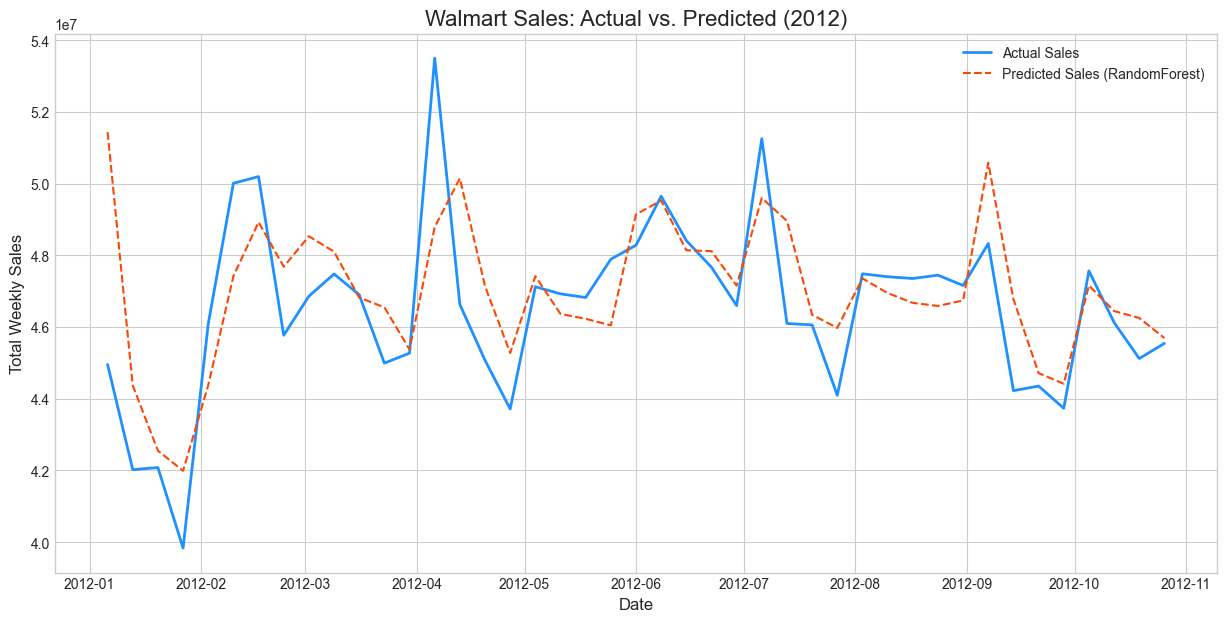

In [22]:
# ## 5. Plot Actual vs. Predicted Values
# Visualize the model's performance by plotting predictions against actual sales.
# We will aggregate sales by date to make the plot readable.

daily_sales = val_df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'Predicted_Sales_RF': 'sum'
}).reset_index()

plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(daily_sales['Date'], daily_sales['Weekly_Sales'], label='Actual Sales', color='dodgerblue', linewidth=2)
ax.plot(daily_sales['Date'], daily_sales['Predicted_Sales_RF'], label='Predicted Sales (RandomForest)', color='orangered', linestyle='--')

ax.set_title('Walmart Sales: Actual vs. Predicted (2012)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Weekly Sales', fontsize=12)
ax.legend()
ax.grid(True)
plt.show()


--- Bonus Section ---


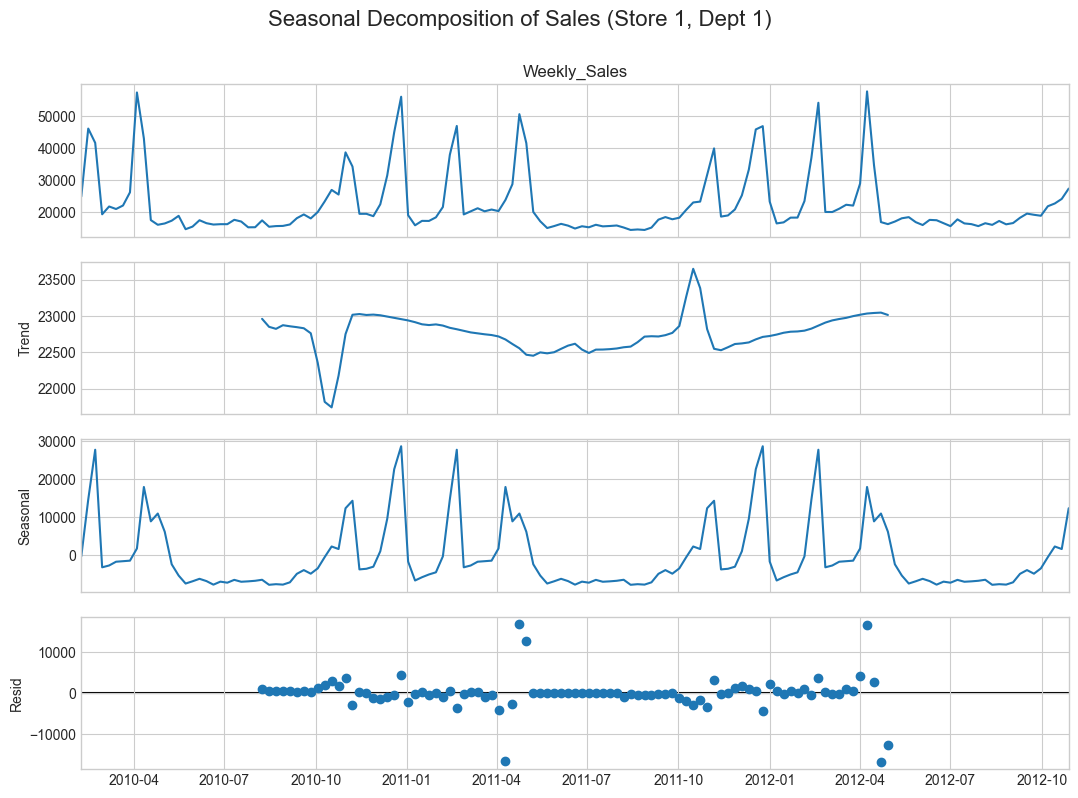

In [23]:
# ## 6. Bonus: Seasonal Decomposition
# Decompose a sample time series (Store 1, Dept 1) to observe trend, seasonality, and residuals.
print("\n--- Bonus Section ---")
# Prepare data for a single store and department
store1_dept1 = df[(df['Store'] == 1) & (df['Dept'] == 1)].copy()
store1_dept1 = store1_dept1.set_index('Date').sort_index()
store1_dept1 = store1_dept1['Weekly_Sales'].resample('W').mean() # Resample to weekly frequency

# Perform decomposition
decomposition = seasonal_decompose(store1_dept1.dropna(), model='additive', period=52) # 52 weeks in a year

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Seasonal Decomposition of Sales (Store 1, Dept 1)', fontsize=16, y=1.02)
plt.show()

In [24]:
# ## 7. Bonus: Apply XGBoost with Time-Aware Validation
# Train an XGBoost model, which is often more powerful for tabular data.
print("\nTraining XGBoost Regressor...")
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    eval_metric='rmse',
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist' # Faster method for large datasets
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    # eval_metric='rmse',
    #early_stopping_rounds=30, # Stop if validation score doesn't improve for 30 rounds
    verbose=False
)


Training XGBoost Regressor...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [25]:
# Make predictions with the XGBoost model
y_pred_xgb = xgb_model.predict(X_val)
val_df['Predicted_Sales_XGB'] = y_pred_xgb
print("XGBoost model trained and predictions made.")

XGBoost model trained and predictions made.


In [26]:
# Evaluate the XGBoost model
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f"XGBoost MAE: ${mae_xgb:,.2f}")
print(f"XGBoost RMSE: ${rmse_xgb:,.2f}")

XGBoost MAE: $1,511.44
XGBoost RMSE: $3,212.00


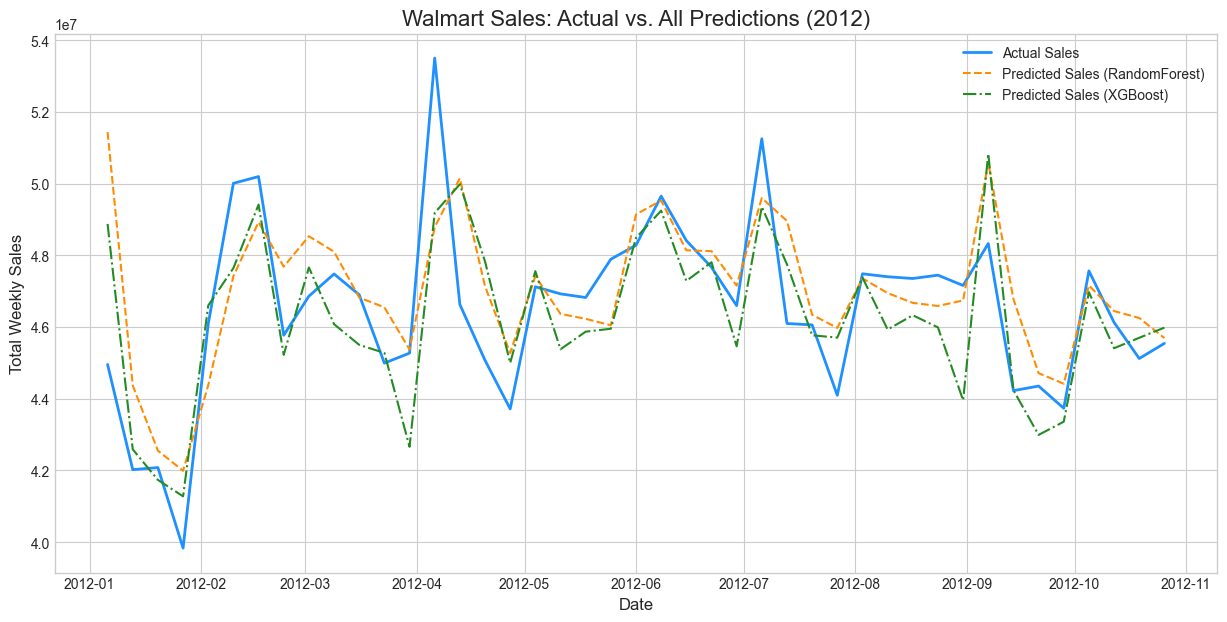

In [27]:
# Plot all three: Actual, RandomForest, and XGBoost
daily_sales_all = val_df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'Predicted_Sales_RF': 'sum',
    'Predicted_Sales_XGB': 'sum'
}).reset_index()

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(daily_sales_all['Date'], daily_sales_all['Weekly_Sales'], label='Actual Sales', color='dodgerblue', linewidth=2)
ax.plot(daily_sales_all['Date'], daily_sales_all['Predicted_Sales_RF'], label='Predicted Sales (RandomForest)', color='darkorange', linestyle='--')
ax.plot(daily_sales_all['Date'], daily_sales_all['Predicted_Sales_XGB'], label='Predicted Sales (XGBoost)', color='forestgreen', linestyle='-.')

ax.set_title('Walmart Sales: Actual vs. All Predictions (2012)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Weekly Sales', fontsize=12)
ax.legend()
ax.grid(True)
plt.show()